# Feature Engineering

In [2]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [3]:
os.chdir(r"C:\Users\amman\Documents\MLOPS\Aircraft-Engine-Predictive-Maintenance")
os.getcwd()

'C:\\Users\\amman\\Documents\\MLOPS\\Aircraft-Engine-Predictive-Maintenance'

### Load the data

In [4]:
train_df = pd.read_csv(r"data\processed\train_FD001_processed.txt")
test_df = pd.read_csv(r"data\processed\test_FD001_processed.txt")

#### Remove unnecessary columns

We will drop the sensors that showed constant values for the whole timeseried data. We will also drop the operational settings columns for this analysis. Additionally, the unit and time data will be removed as they are deemed not important for prediction purposes. The unit and time will be kept for now and only be removed at the end as they are needed for the feature engineering.

In [5]:
drop_sensors = ['sensor_1','sensor_5','sensor_6','sensor_10','sensor_16','sensor_18','sensor_19']
drop_labels = ["setting_1", "setting_2", "setting_3"]+drop_sensors

train_df = train_df.drop(drop_labels, axis=1)
test_df = test_df.drop(drop_labels, axis=1)

#### Create model training function

In [6]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    
    return mae, mse, rmse, r2


def train_models(X_train, y_train, X_test, y_test):
    models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "KNN Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False)
}

    model_list = []
    model_metrics = {}

    for i in range(len(list(models))):

        # Train model
        model = list(models.values())[i]
        model.fit(X_train, y_train)

        # Model predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate training and test sets
        model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        print(list(models.keys())[i] + ":")
        model_list.append(list(models.keys())[i])

        model_metrics[model_list[-1]] = [model_train_mae, model_train_mse, model_train_rmse, model_train_r2, model_test_mae, model_test_mse, model_test_rmse, model_test_r2]



        print("Model Performance for Training Set")
        print("- Mean Absolute Error (MAE): {:.4f}".format(model_train_mae))
        print("- Mean Squared Error (MSE): {:.4f}".format(model_train_mse))
        print("- Root Mean Squared Error (RMSE) {:.4f}".format(model_train_rmse))
        print("- R2 Score: {:.4f}".format(model_train_r2))
        print("\n")
        print("Model Performance for Test Set")
        print("- Mean Absolute Error (MAE): {:.4f}".format(model_test_mae))
        print("- Mean Squared Error (MSE): {:.4f}".format(model_test_mse))
        print("- Root Mean Squared Error (RMSE) {:.4f}".format(model_test_rmse))
        print("- R2 Score: {:.4f}".format(model_test_r2))


        print('='*35)
        print("\n")

    return model_metrics

In [7]:
def get_results_table(model_metrics):

    return pd.DataFrame(model_metrics, index=["Train_MAE", "Train_MSE", "Train_RMSE", "Train_R2", "Test_MAE", "Test_MSE", "Test_RMSE", "Test_R2"]).T.sort_values("Test_RMSE")

##### Rolling Mean (Signal Smoothening)

In [8]:
# Apply rolling mean for each sensor feature (window = 5 cycles)
window_size = 5
sensor_columns = [col for col in train_df.columns if "sensor" in col]  # Select sensor columns

# Compute rolling mean
for col in sensor_columns:
    train_df[f"{col}_rolling_mean"] = train_df.groupby("unit")[col].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
    test_df[f"{col}_rolling_mean"] = test_df.groupby("unit")[col].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)

In [9]:
X_train = train_df.copy() 
y_train = X_train.pop("RUL")
X_test = test_df.copy()
y_test = X_test.pop("RUL")

In [10]:
rolling_mean_model_perf = train_models(X_train, y_train, X_test, y_test)

Linear Regression:
Model Performance for Training Set
- Mean Absolute Error (MAE): 30.3232
- Mean Squared Error (MSE): 1553.1485
- Root Mean Squared Error (RMSE) 39.4100
- R2 Score: 0.6726


Model Performance for Test Set
- Mean Absolute Error (MAE): 26.3267
- Mean Squared Error (MSE): 1032.3197
- Root Mean Squared Error (RMSE) 32.1297
- R2 Score: 0.4022


Ridge:
Model Performance for Training Set
- Mean Absolute Error (MAE): 30.3233
- Mean Squared Error (MSE): 1553.1485
- Root Mean Squared Error (RMSE) 39.4100
- R2 Score: 0.6726


Model Performance for Test Set
- Mean Absolute Error (MAE): 26.3261
- Mean Squared Error (MSE): 1032.2783
- Root Mean Squared Error (RMSE) 32.1291
- R2 Score: 0.4022


Lasso:
Model Performance for Training Set
- Mean Absolute Error (MAE): 30.3596
- Mean Squared Error (MSE): 1559.6953
- Root Mean Squared Error (RMSE) 39.4930
- R2 Score: 0.6713


Model Performance for Test Set
- Mean Absolute Error (MAE): 26.2246
- Mean Squared Error (MSE): 1001.1615
- Root Me

In [11]:
get_results_table(rolling_mean_model_perf)

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Lasso,30.359616,1559.695286,39.492978,0.671253,26.224590,1001.161463,31.641136,0.420245
Ridge,30.323260,1553.148501,39.410005,0.672633,26.326064,1032.278332,32.129089,0.402226
Linear Regression,30.323248,1553.148486,39.410005,0.672633,26.326650,1032.319665,32.129732,0.402202
AdaBoost Regressor,29.771369,1288.100605,35.890118,0.728499,27.658162,1088.296917,32.989346,0.369786
Random Forest Regressor,2.368770,12.465575,3.530662,0.997373,22.935200,1230.504726,35.078551,0.287436
KNN Regressor,8.132800,248.302568,15.757619,0.947664,28.382000,1378.299600,37.125458,0.201851
CatBoosting Regressor,3.402736,20.359088,4.512105,0.995709,28.076674,1402.463041,37.449473,0.187858
XGBRegressor,3.306984,20.321680,4.507957,0.995717,27.644253,1508.093262,38.834176,0.126689
Decision Tree,0.000000,0.000000,0.000000,1.000000,29.730000,1762.210000,41.978685,-0.020465


Adding rolling mean of sensor data has slightly improved results

#### Piece-wise Linear Degradation

Up until now, we have assumed that the RUL decreases linearly at every cycle for each unit. This means we are assuming that the unit is showing signs of degradation from the very first time cycle up until failure. However, from the data description and from the sensor plots, it seems like a piece wise linear degradation model might be more appropriate. That is to say that instead of RUL decreasing from the very first time cycle of each unit, we clip the RUL to an arbitrary value, say 125 so that the RUL remains constant for some time cycles and then when RUL becomes less than 125, thats when we assume degradation begins and we can start linearly reducing the RUL after each cycle.

Below is a plot showing Sensor 12 data plotted against RUL

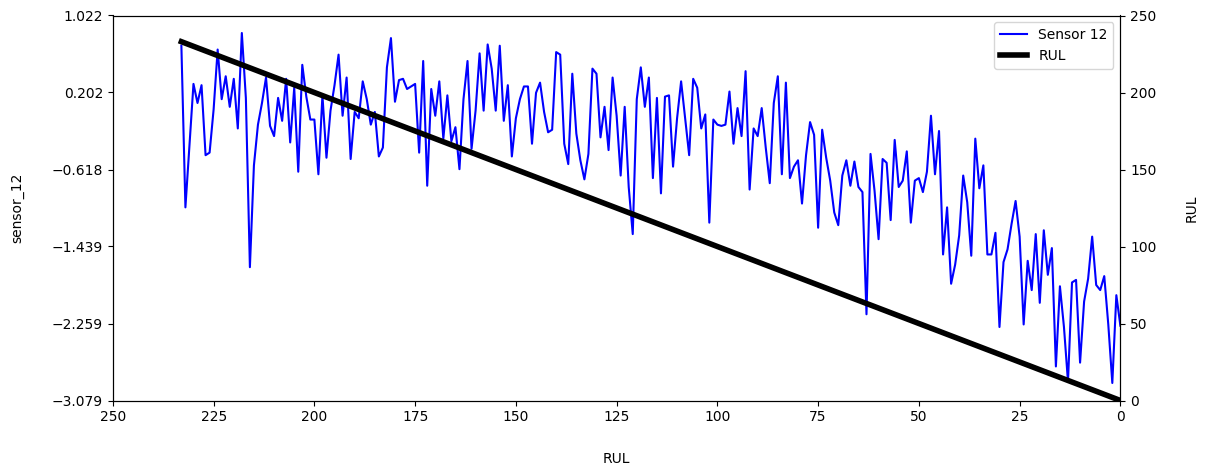

In [12]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

# Plot sensor 12 values against RUL
signal = ax1.plot(train_df.loc[train_df['unit']==20, 'RUL'], 
                  train_df.loc[train_df['unit']==20, 'sensor_12'], 'b', label='Sensor 12')

plt.xlim(250, 0)  # reverse x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('sensor_12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

# Add secondary y-axis for RUL
ax2 = ax1.twinx()
rul_line = ax2.plot(train_df.loc[train_df['unit']==20, 'RUL'], 
                    train_df.loc[train_df['unit']==20, 'RUL'], 'k', linewidth=4, label='RUL')
ax2.set_ylabel('RUL', labelpad=20)

# Align tick marks for both y-axes
ax2.set_ylim(0, 250)
ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))
ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))

# Unified legend
lines = signal + rul_line
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.show()

For cycle 250 - 100 (or so) the mean sensor signal is rather stable, while computed RUL is declining.
Below 100 cycles, both the mean sensor signal and computed RUL are declining. In essence, the higher correlation between the sensor signal and computed RUL at lower RUL values makes it easier for the algorithm to produce more accurate predictions.

In [13]:
clipped_rul = train_df.loc[train_df['unit']==20].copy()
clipped_rul['RUL'].clip(upper=125, inplace=True)

C:\Users\amman\AppData\Local\Temp\ipykernel_4964\3464880680.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clipped_rul['RUL'].clip(upper=125, inplace=True)


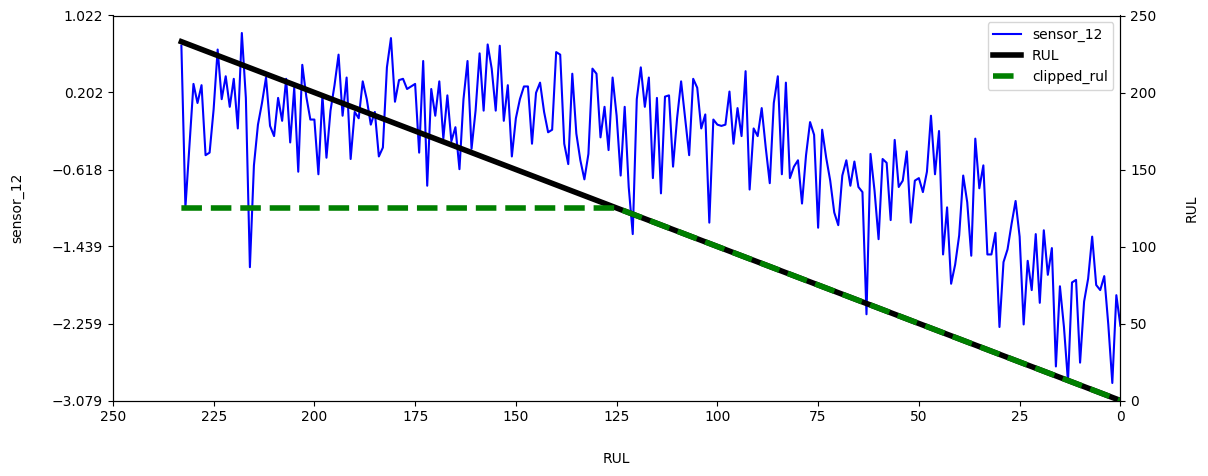

In [14]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 'sensor_12', 'b',
                 data=train_df.loc[train_df['unit']==20])
plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('sensor_12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=4,
                   data=train_df.loc[train_df['unit']==20])
rul = train_df.loc[train_df['unit']==20, 'RUL']
rul_line2 = ax2.plot(rul, rul.where(rul <= 125, 125), '--g', linewidth=4, label='clipped_rul') 
ax2.set_ylabel('RUL', labelpad=20)

# code to have equal spacing of y ticks for both axes, so the gridlines allign
# from https://stackoverflow.com/questions/20243683/matplotlib-align-twinx-tick-marks?rq=1
ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis


# code to have a unified legend
# from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = signal+rul_line+rul_line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.show()

We will apply this principle to our training set and re-train the models to see if performance improves

In [15]:
# Apply piecewise linear degradation
train_df["RUL"] = train_df["RUL"].clip(upper=125)

In [16]:
X_train = train_df.copy()
y_train = X_train.pop("RUL")
X_test = test_df.copy()
y_test = X_test.pop("RUL")

In [17]:
rolling_mean_and_piece_wise_model = train_models(X_train, y_train, X_test, y_test)

Linear Regression:
Model Performance for Training Set
- Mean Absolute Error (MAE): 15.9559
- Mean Squared Error (MSE): 384.8789
- Root Mean Squared Error (RMSE) 19.6183
- R2 Score: 0.7784


Model Performance for Test Set
- Mean Absolute Error (MAE): 17.5387
- Mean Squared Error (MSE): 513.9626
- Root Mean Squared Error (RMSE) 22.6707
- R2 Score: 0.7024


Ridge:
Model Performance for Training Set
- Mean Absolute Error (MAE): 15.9559
- Mean Squared Error (MSE): 384.8789
- Root Mean Squared Error (RMSE) 19.6183
- R2 Score: 0.7784


Model Performance for Test Set
- Mean Absolute Error (MAE): 17.5389
- Mean Squared Error (MSE): 513.9516
- Root Mean Squared Error (RMSE) 22.6705
- R2 Score: 0.7024


Lasso:
Model Performance for Training Set
- Mean Absolute Error (MAE): 16.0244
- Mean Squared Error (MSE): 390.2027
- Root Mean Squared Error (RMSE) 19.7535
- R2 Score: 0.7753


Model Performance for Test Set
- Mean Absolute Error (MAE): 18.3874
- Mean Squared Error (MSE): 536.1199
- Root Mean Squ

In [18]:
get_results_table(rolling_mean_and_piece_wise_model)

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
AdaBoost Regressor,16.518993,369.853815,19.231584,0.787026,16.913055,434.429749,20.842978,0.748429
Ridge,15.955877,384.878938,19.618332,0.778374,17.538855,513.951581,22.670500,0.702380
Linear Regression,15.955887,384.878928,19.618331,0.778374,17.538677,513.962598,22.670743,0.702373
Random Forest Regressor,1.747834,7.818744,2.796202,0.995498,16.277600,515.001818,22.693651,0.701771
Lasso,16.024359,390.202700,19.753549,0.775308,18.387441,536.119931,23.154264,0.689542
XGBRegressor,2.054424,8.434769,2.904267,0.995143,18.528000,641.850647,25.334772,0.628315
CatBoosting Regressor,2.678256,13.626704,3.691437,0.992153,20.102160,706.738960,26.584562,0.590740
KNN Regressor,2.616344,35.284597,5.940084,0.979682,21.704000,799.253600,28.271074,0.537166
Decision Tree,0.000000,0.000000,0.000000,1.000000,22.580000,911.520000,30.191390,0.472155


Introducing the piece-wise degradation for RUL has led to a substantial increase in performance with respect to the baseline models.

#### Adding lag features

In [19]:
# Create copy of train set
train_lag_df = train_df.copy()

# Define lag steps
lag_steps = [1, 5, 10]  

# Select sensor columns to apply lag on
sensor_cols = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 
               'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 
               'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

# Create lag features for each selected sensor
for lag in lag_steps:
    for col in sensor_cols:
        train_lag_df[f'{col}_lag{lag}'] = train_lag_df.groupby('unit')[col].shift(lag)

# Handle NaNs
train_lag_df.fillna(method='bfill', inplace=True)

# Verify result
train_lag_df.head()

C:\Users\amman\AppData\Local\Temp\ipykernel_4964\4089142250.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_lag_df.fillna(method='bfill', inplace=True)


,unit,time,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,...,sensor_8_lag10,sensor_9_lag10,sensor_11_lag10,sensor_12_lag10,sensor_13_lag10,sensor_14_lag10,sensor_15_lag10,sensor_17_lag10,sensor_20_lag10,sensor_21_lag10
0,1,1,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,...,-0.516338,-0.862813,-0.266467,0.334262,-1.05889,-0.269071,-0.603816,-0.78171,1.348493,1.194427
1,1,2,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.191583,1.174899,...,-0.516338,-0.862813,-0.266467,0.334262,-1.05889,-0.269071,-0.603816,-0.78171,1.348493,1.194427
2,1,3,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-1.015303,1.364721,...,-0.516338,-0.862813,-0.266467,0.334262,-1.05889,-0.269071,-0.603816,-0.78171,1.348493,1.194427
3,1,4,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,-1.539489,1.961302,...,-0.516338,-0.862813,-0.266467,0.334262,-1.05889,-0.269071,-0.603816,-0.78171,1.348493,1.194427
4,1,5,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,-0.977861,1.052871,...,-0.516338,-0.862813,-0.266467,0.334262,-1.05889,-0.269071,-0.603816,-0.78171,1.348493,1.194427


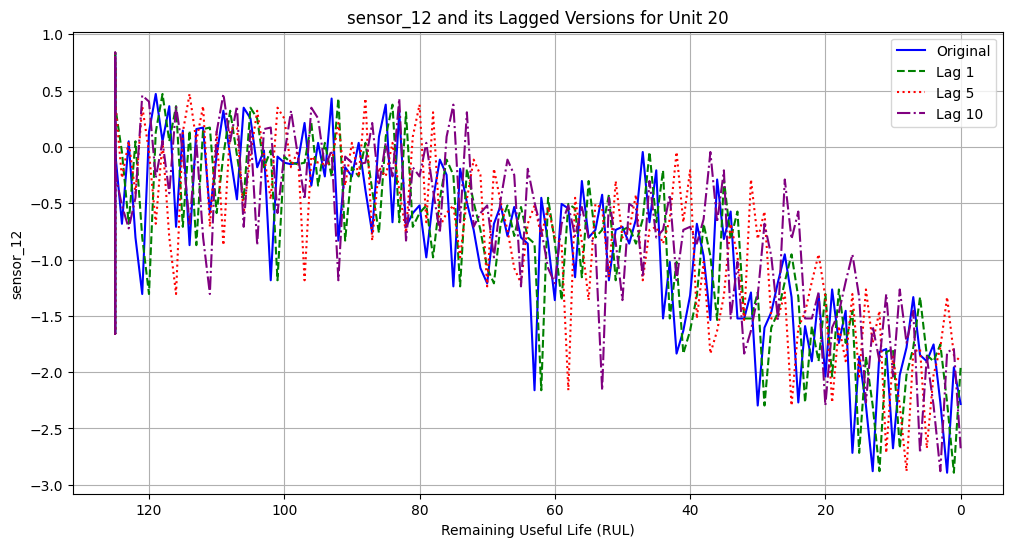

In [58]:
# Select a specific engine unit
unit_id = 20
sensor_to_plot = 'sensor_12'

# Filter data for the selected unit
unit_data = train_lag_df[train_lag_df['unit'] == unit_id]

# Plot original sensor values and lagged values
plt.figure(figsize=(12, 6))

plt.plot(unit_data['RUL'], unit_data[sensor_to_plot], label='Original', color='blue')
plt.plot(unit_data['RUL'], unit_data[f'{sensor_to_plot}_lag1'], label='Lag 1', linestyle='dashed', color='green')
plt.plot(unit_data['RUL'], unit_data[f'{sensor_to_plot}_lag5'], label='Lag 5', linestyle='dotted', color='red')
plt.plot(unit_data['RUL'], unit_data[f'{sensor_to_plot}_lag10'], label='Lag 10', linestyle='dashdot', color='purple')

plt.gca().invert_xaxis() 
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel(sensor_to_plot)
plt.title(f'{sensor_to_plot} and its Lagged Versions for Unit {unit_id}')
plt.legend()
plt.grid()

plt.show()

In [20]:
X_train = train_lag_df
y_train = X_train.pop("RUL")
X_test = test_df.copy()
y_test = X_test.pop("RUL")

In [21]:
# Ensure both training and test sets have the same lag columns
lag_columns = [col for col in X_train.columns if "lag" in col]  # add all lag columns here

# Add these lag columns to the test set, filled with NaN or 0
for col in lag_columns:
    if col not in X_test.columns:
        X_test[col] = 0  

# Re-order columns to ensure both train and test have the same order
X_train = X_train[lag_columns + [col for col in X_train.columns if col not in lag_columns]]
X_test = X_test[lag_columns + [col for col in X_test.columns if col not in lag_columns]]

In [22]:
X_train

,sensor_2_lag1,sensor_3_lag1,sensor_4_lag1,sensor_7_lag1,sensor_8_lag1,sensor_9_lag1,sensor_11_lag1,sensor_12_lag1,sensor_13_lag1,sensor_14_lag1,...,sensor_8_rolling_mean,sensor_9_rolling_mean,sensor_11_rolling_mean,sensor_12_rolling_mean,sensor_13_rolling_mean,sensor_14_rolling_mean,sensor_15_rolling_mean,sensor_17_rolling_mean,sensor_20_rolling_mean,sensor_21_rolling_mean
0,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,...,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427
1,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,...,-0.657216,-0.910815,-0.229025,0.754581,-0.711268,-0.455958,-0.439834,-0.781710,1.182510,1.215675
2,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,...,-0.516338,-0.792923,-0.491118,0.957961,-0.780793,-0.487848,-0.509604,-1.212171,1.034970,0.978257
3,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,...,-0.340242,-0.773149,-0.753210,1.208796,-0.641744,-0.495930,-0.875119,-1.104556,0.864377,0.928141
4,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,...,-0.375461,-0.709931,-0.798141,1.177611,-0.669553,-0.501094,-0.768064,-0.910848,0.784153,0.954423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,1.458013,1.552256,2.551692,-2.200628,1.878576,0.201385,2.541671,-2.309679,2.556380,-0.044702,...,1.765874,0.053122,2.302043,-2.065623,1.888945,-0.137490,2.079089,1.671921,-2.258858,-1.940589
20627,1.618000,1.216258,2.188375,-2.189329,1.315066,0.012547,1.980044,-2.607969,2.278282,-0.322542,...,1.934927,0.095328,2.197206,-2.312390,1.916755,-0.210462,2.210808,1.413644,-2.546561,-1.788346
20628,1.717992,2.279706,2.738351,-2.833345,1.878576,-0.006020,1.867718,-2.350355,1.722087,-0.380207,...,1.794049,0.080203,2.122322,-2.339508,2.055804,-0.220632,2.329195,1.542782,-2.579758,-1.954076
20629,1.478011,1.946971,2.138377,-2.742957,2.019453,0.029755,2.054927,-1.902919,2.000184,-0.141684,...,1.850400,0.124310,2.324508,-2.306967,2.083614,-0.224617,2.421984,1.671921,-2.679347,-2.080453


In [23]:
X_test

,sensor_2_lag1,sensor_3_lag1,sensor_4_lag1,sensor_7_lag1,sensor_8_lag1,sensor_9_lag1,sensor_11_lag1,sensor_12_lag1,sensor_13_lag1,sensor_14_lag1,...,sensor_8_rolling_mean,sensor_9_rolling_mean,sensor_11_rolling_mean,sensor_12_rolling_mean,sensor_13_rolling_mean,sensor_14_rolling_mean,sensor_15_rolling_mean,sensor_17_rolling_mean,sensor_20_rolling_mean,sensor_21_rolling_mean
0,0,0,0,0,0,0,0,0,0,0,...,-0.234584,-0.400453,-1.165071,0.510525,-0.502695,-0.715188,-1.059765,-0.136018,-0.034694,0.605041
1,0,0,0,0,0,0,0,0,0,0,...,0.047171,-0.927118,0.482370,0.442731,-0.085548,-0.883465,0.222760,-1.427402,-0.034694,-0.257790
2,0,0,0,0,0,0,0,0,0,0,...,0.892435,-0.723788,1.268649,-0.791108,0.609696,-0.644417,-0.806460,1.155367,0.629236,-0.145087
3,0,0,0,0,0,0,0,0,0,0,...,0.469803,-0.631407,0.407486,0.632553,0.192549,-0.530136,0.566722,1.155367,-1.307226,-0.291971
4,0,0,0,0,0,0,0,0,0,0,...,0.047171,-0.509590,-0.303908,-0.560610,0.748745,-0.944275,-0.158531,0.509675,-0.366659,1.126989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,-0.938970,-0.128290,-1.502047,1.202017,-1.197939,0.235235,-0.830457,-1.427402,0.795218,1.578729
96,0,0,0,0,0,0,0,0,0,0,...,-0.516338,0.503437,-0.603443,0.225792,-0.502695,0.614775,0.209428,1.155367,-1.141243,0.051683
97,0,0,0,0,0,0,0,0,0,0,...,0.469803,-0.131460,0.444928,0.157999,-0.085548,0.138253,-0.497161,0.509675,-0.311331,0.656774
98,0,0,0,0,0,0,0,0,0,0,...,-1.220725,0.086814,-1.052745,0.551201,-1.058890,0.347420,-1.115759,-1.427402,0.739891,0.644765


In [24]:
rolling_mean_and_piece_wise_with_lag_model = train_models(X_train, y_train, X_test, y_test)

Linear Regression:
Model Performance for Training Set
- Mean Absolute Error (MAE): 15.4948
- Mean Squared Error (MSE): 364.6514
- Root Mean Squared Error (RMSE) 19.0958
- R2 Score: 0.7900


Model Performance for Test Set
- Mean Absolute Error (MAE): 19.5105
- Mean Squared Error (MSE): 590.2802
- Root Mean Squared Error (RMSE) 24.2957
- R2 Score: 0.6582


Ridge:
Model Performance for Training Set
- Mean Absolute Error (MAE): 15.4948
- Mean Squared Error (MSE): 364.6514
- Root Mean Squared Error (RMSE) 19.0958
- R2 Score: 0.7900


Model Performance for Test Set
- Mean Absolute Error (MAE): 19.5102
- Mean Squared Error (MSE): 590.2270
- Root Mean Squared Error (RMSE) 24.2946
- R2 Score: 0.6582


Lasso:
Model Performance for Training Set
- Mean Absolute Error (MAE): 15.9895
- Mean Squared Error (MSE): 388.7348
- Root Mean Squared Error (RMSE) 19.7164
- R2 Score: 0.7762


Model Performance for Test Set
- Mean Absolute Error (MAE): 21.6033
- Mean Squared Error (MSE): 683.1213
- Root Mean Squ

In [25]:
get_results_table(rolling_mean_and_piece_wise_with_lag_model)

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Random Forest Regressor,2.080663,10.658612,3.264753,0.993862,16.165800,497.934966,22.314456,0.711655
AdaBoost Regressor,18.203385,434.370303,20.841552,0.749875,18.805101,513.115230,22.652047,0.702864
Ridge,15.494825,364.651362,19.095847,0.790022,19.510174,590.227024,24.294588,0.658210
Linear Regression,15.494794,364.651351,19.095846,0.790022,19.510485,590.280195,24.295683,0.658179
XGBRegressor,2.281903,10.429201,3.229427,0.993995,18.631973,636.396118,25.226893,0.631474
Lasso,15.989463,388.734843,19.716360,0.776153,21.603308,683.121261,26.136589,0.604416
CatBoosting Regressor,2.823425,15.194610,3.898026,0.991250,21.712026,776.349688,27.863052,0.550429
Decision Tree,0.000000,0.000000,0.000000,1.000000,22.630000,874.850000,29.577863,0.493390
KNN Regressor,2.588677,35.553435,5.962670,0.979527,29.276000,1351.465600,36.762285,0.217390


Adding the lag features has degraded model performance. We will not continue with lag feature implementation.

Current best model

In [26]:
get_results_table(rolling_mean_and_piece_wise_model)

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
AdaBoost Regressor,16.518993,369.853815,19.231584,0.787026,16.913055,434.429749,20.842978,0.748429
Ridge,15.955877,384.878938,19.618332,0.778374,17.538855,513.951581,22.670500,0.702380
Linear Regression,15.955887,384.878928,19.618331,0.778374,17.538677,513.962598,22.670743,0.702373
Random Forest Regressor,1.747834,7.818744,2.796202,0.995498,16.277600,515.001818,22.693651,0.701771
Lasso,16.024359,390.202700,19.753549,0.775308,18.387441,536.119931,23.154264,0.689542
XGBRegressor,2.054424,8.434769,2.904267,0.995143,18.528000,641.850647,25.334772,0.628315
CatBoosting Regressor,2.678256,13.626704,3.691437,0.992153,20.102160,706.738960,26.584562,0.590740
KNN Regressor,2.616344,35.284597,5.940084,0.979682,21.704000,799.253600,28.271074,0.537166
Decision Tree,0.000000,0.000000,0.000000,1.000000,22.580000,911.520000,30.191390,0.472155


##### Feature Selection

We will now remove the unit and time columns as they are no longer needed. We will also remove highly correlated features to avoid multicolinearity issues.

In [27]:
columns_to_drop = ["unit", "time"]
train_df.drop(columns_to_drop, axis=1, inplace=True)
test_df.drop(columns_to_drop, axis=1, inplace=True)

In [28]:
correlation_matrix = train_df.corr()
correlation_matrix = correlation_matrix.abs()  # Absolute correlation values
np.fill_diagonal(correlation_matrix.values, 0)

# Find features that are highly correlated (greater than 0.9)
highly_correlated_pairs = np.where(correlation_matrix > 0.9)

# Get the column names for the highly correlated features
correlated_features = set()
for i, j in zip(*highly_correlated_pairs):
    correlated_features.add(train_df.columns[i])
    correlated_features.add(train_df.columns[j])

train_df_reduced = train_df.drop(columns=correlated_features, axis=1)
test_df_reduced = test_df.drop(columns=correlated_features, axis=1)


In [29]:
train_df_reduced.shape

(20631, 7)

In [30]:
test_df_reduced.shape

(100, 7)

In [31]:
train_df_reduced.columns

Index(['sensor_2', 'sensor_3', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21', 'RUL'],
      dtype='object')

Let's re-train the models based on thee reduced datasets

In [32]:
X_train = train_df_reduced
y_train = X_train.pop("RUL")
X_test = test_df_reduced
y_test = X_test.pop("RUL")

In [33]:
rolling_mean_and_piece_wise_model_reduced = train_models(X_train, y_train, X_test, y_test)

Linear Regression:
Model Performance for Training Set
- Mean Absolute Error (MAE): 19.4606
- Mean Squared Error (MSE): 570.7755
- Root Mean Squared Error (RMSE) 23.8909
- R2 Score: 0.6713


Model Performance for Test Set
- Mean Absolute Error (MAE): 19.1370
- Mean Squared Error (MSE): 558.9278
- Root Mean Squared Error (RMSE) 23.6417
- R2 Score: 0.6763


Ridge:
Model Performance for Training Set
- Mean Absolute Error (MAE): 19.4606
- Mean Squared Error (MSE): 570.7755
- Root Mean Squared Error (RMSE) 23.8909
- R2 Score: 0.6713


Model Performance for Test Set
- Mean Absolute Error (MAE): 19.1371
- Mean Squared Error (MSE): 558.9298
- Root Mean Squared Error (RMSE) 23.6417
- R2 Score: 0.6763


Lasso:
Model Performance for Training Set
- Mean Absolute Error (MAE): 19.5611
- Mean Squared Error (MSE): 572.1891
- Root Mean Squared Error (RMSE) 23.9205
- R2 Score: 0.6705


Model Performance for Test Set
- Mean Absolute Error (MAE): 19.5618
- Mean Squared Error (MSE): 570.1013
- Root Mean Squ

In [34]:
get_results_table(rolling_mean_and_piece_wise_model_reduced)

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
CatBoosting Regressor,15.159813,393.651960,19.840664,0.773322,16.318004,450.031364,21.213943,0.739395
XGBRegressor,12.868740,295.329498,17.185153,0.829939,16.383635,456.857178,21.374218,0.735442
Random Forest Regressor,6.534090,73.806969,8.591098,0.957499,17.061700,502.821961,22.423692,0.708825
Linear Regression,19.460594,570.775497,23.890908,0.671328,19.137028,558.927811,23.641654,0.676335
Ridge,19.460616,570.775498,23.890908,0.671328,19.137130,558.929802,23.641696,0.676334
KNN Regressor,14.562813,397.533252,19.938236,0.771087,17.560000,560.024800,23.664843,0.675699
Lasso,19.561114,572.189127,23.920475,0.670514,19.561832,570.101265,23.876793,0.669864
AdaBoost Regressor,21.308753,611.518512,24.728900,0.647867,19.695792,604.351086,24.583553,0.650031
Decision Tree,0.000000,0.000000,0.000000,1.000000,26.110000,1211.290000,34.803592,0.298563


There is a slight degradation in model performance after removing highly correlated features however the training time has reduced significantly.

##### Feature selection using RandomForest feature importance

In [35]:
X_train = train_df.copy()
y_train = X_train.pop("RUL")
X_test = test_df.copy()
y_test = X_test.pop("RUL")

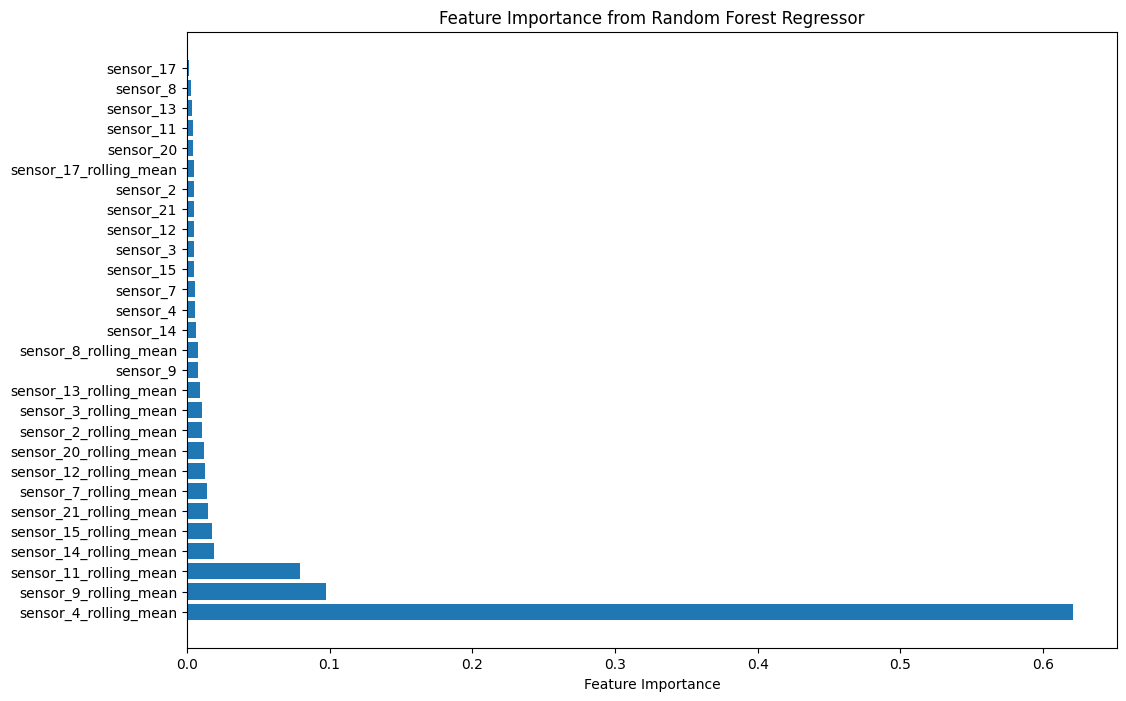

In [36]:
# Fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a dataframe to hold feature names and importance values
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Regressor')
plt.show()

We can see that the rolling means have high importance in predicting RUL. Let's try and create a reduced train and test set based on the top 10 most important features found by random forest model

In [37]:
# print top 10 important features
print(feature_importance_df.head(10)) 

                   Feature  Importance
16   sensor_4_rolling_mean    0.620560
19   sensor_9_rolling_mean    0.097773
20  sensor_11_rolling_mean    0.079411
23  sensor_14_rolling_mean    0.019327
24  sensor_15_rolling_mean    0.017727
27  sensor_21_rolling_mean    0.014692
17   sensor_7_rolling_mean    0.014383
21  sensor_12_rolling_mean    0.012780
26  sensor_20_rolling_mean    0.012056
14   sensor_2_rolling_mean    0.010571


In [38]:
columns_to_keep = [col for col in feature_importance_df['Feature'].head(10)] + ["RUL"]
columns_to_keep

['sensor_4_rolling_mean',
 'sensor_9_rolling_mean',
 'sensor_11_rolling_mean',
 'sensor_14_rolling_mean',
 'sensor_15_rolling_mean',
 'sensor_21_rolling_mean',
 'sensor_7_rolling_mean',
 'sensor_12_rolling_mean',
 'sensor_20_rolling_mean',
 'sensor_2_rolling_mean',
 'RUL']

In [39]:
train_df_rf_reduced = train_df[columns_to_keep]
test_df_rf_reduced = test_df[columns_to_keep]

In [40]:
X_train = train_df_rf_reduced
y_train = X_train.pop("RUL")
X_test = test_df_rf_reduced
y_test = X_test.pop("RUL")

In [41]:
rolling_mean_and_piece_wise_model_rf_reduced = train_models(X_train, y_train, X_test, y_test)

Linear Regression:
Model Performance for Training Set
- Mean Absolute Error (MAE): 17.3837
- Mean Squared Error (MSE): 449.7814
- Root Mean Squared Error (RMSE) 21.2081
- R2 Score: 0.7410


Model Performance for Test Set
- Mean Absolute Error (MAE): 17.3085
- Mean Squared Error (MSE): 483.1413
- Root Mean Squared Error (RMSE) 21.9805
- R2 Score: 0.7202


Ridge:
Model Performance for Training Set
- Mean Absolute Error (MAE): 17.3837
- Mean Squared Error (MSE): 449.7814
- Root Mean Squared Error (RMSE) 21.2081
- R2 Score: 0.7410


Model Performance for Test Set
- Mean Absolute Error (MAE): 17.3083
- Mean Squared Error (MSE): 483.1330
- Root Mean Squared Error (RMSE) 21.9803
- R2 Score: 0.7202


Lasso:
Model Performance for Training Set
- Mean Absolute Error (MAE): 17.4583
- Mean Squared Error (MSE): 452.2453
- Root Mean Squared Error (RMSE) 21.2661
- R2 Score: 0.7396


Model Performance for Test Set
- Mean Absolute Error (MAE): 17.7534
- Mean Squared Error (MSE): 493.3596
- Root Mean Squ

Best model so far results

In [42]:
get_results_table(rolling_mean_and_piece_wise_model)

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
AdaBoost Regressor,16.518993,369.853815,19.231584,0.787026,16.913055,434.429749,20.842978,0.748429
Ridge,15.955877,384.878938,19.618332,0.778374,17.538855,513.951581,22.670500,0.702380
Linear Regression,15.955887,384.878928,19.618331,0.778374,17.538677,513.962598,22.670743,0.702373
Random Forest Regressor,1.747834,7.818744,2.796202,0.995498,16.277600,515.001818,22.693651,0.701771
Lasso,16.024359,390.202700,19.753549,0.775308,18.387441,536.119931,23.154264,0.689542
XGBRegressor,2.054424,8.434769,2.904267,0.995143,18.528000,641.850647,25.334772,0.628315
CatBoosting Regressor,2.678256,13.626704,3.691437,0.992153,20.102160,706.738960,26.584562,0.590740
KNN Regressor,2.616344,35.284597,5.940084,0.979682,21.704000,799.253600,28.271074,0.537166
Decision Tree,0.000000,0.000000,0.000000,1.000000,22.580000,911.520000,30.191390,0.472155


Feature selection with random forest results

In [43]:
get_results_table(rolling_mean_and_piece_wise_model_rf_reduced)

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Random Forest Regressor,3.912459,33.093163,5.752666,0.980944,15.044500,421.205321,20.523287,0.756087
AdaBoost Regressor,16.932064,408.924837,20.221890,0.764527,16.429404,452.508258,21.272241,0.737960
KNN Regressor,6.431254,115.962100,10.768570,0.933225,15.622000,457.530800,21.389970,0.735052
Ridge,17.383685,449.781443,21.208051,0.741001,17.308290,483.132956,21.980286,0.720226
Linear Regression,17.383683,449.781442,21.208051,0.741001,17.308524,483.141250,21.980474,0.720221
CatBoosting Regressor,9.192445,170.038903,13.039897,0.902086,15.538715,493.119605,22.206297,0.714443
Lasso,17.458307,452.245262,21.266059,0.739582,17.753382,493.359581,22.211699,0.714304
XGBRegressor,7.425756,117.312347,10.831082,0.932448,16.412516,543.357788,23.310036,0.685351
Decision Tree,0.000000,0.000000,0.000000,1.000000,22.170000,893.370000,29.889296,0.482665


The model performance has slightly improved even by reducing the number of features. We will now take the top 3 best performing models and perform hyper paramter tuning to see if further performance enhancement can be achieved. We will also try and create a stack model from the tuned models to see if better performance can be achieved.

### Hyper Parameter Tuning

In [46]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

# Random Forest Model
rf_param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)

rf_random_search = RandomizedSearchCV(estimator=rf_model, 
                                      param_distributions=rf_param_grid, 
                                      n_iter=20,  
                                      cv=5, 
                                      verbose=2, 
                                      random_state=42, 
                                      n_jobs=-1)

# AdaBoost Model
ada_param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': np.linspace(0.01, 1, 10)
}

ada_model = AdaBoostRegressor(random_state=42)

ada_random_search = RandomizedSearchCV(estimator=ada_model, 
                                       param_distributions=ada_param_grid, 
                                       n_iter=20, 
                                       cv=5, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs=-1)

# KNN Model
knn_param_grid = {
    'n_neighbors': np.arange(3, 30, 2),  # Odd numbers to avoid ties
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn_model = KNeighborsRegressor()

knn_random_search = RandomizedSearchCV(estimator=knn_model, 
                                       param_distributions=knn_param_grid, 
                                       n_iter=20, 
                                       cv=5, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs=-1)


# Model training
# Fit GridSearchCV for Random Forest Regressor
rf_random_search.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random_search.best_params_}")

# Fit GridSearchCV for AdaBoost Regressor
ada_random_search.fit(X_train, y_train)
print(f"Best AdaBoost Params: {ada_random_search.best_params_}")

# Fit GridSearchCV for KNN Regressor
knn_random_search.fit(X_train, y_train)
print(f"Best KNN Params: {knn_random_search.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest Params: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best AdaBoost Params: {'n_estimators': 250, 'learning_rate': 0.01}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best KNN Params: {'weights': 'uniform', 'n_neighbors': 29, 'algorithm': 'auto'}


In [48]:
from sklearn.ensemble import VotingRegressor

# Get the best models from GridSearchCV
best_rf_model = rf_random_search.best_estimator_
best_ada_model = ada_random_search.best_estimator_
best_knn_model = knn_random_search.best_estimator_

# Make preditions
y_train_pred_tuned_rf = best_rf_model.predict(X_train)
y_test_pred_tuned_rf = best_rf_model.predict(X_test)

y_train_pred_tuned_ada = best_ada_model.predict(X_train)
y_test_pred_tuned_ada = best_ada_model.predict(X_test)

y_train_pred_tuned_knn = best_knn_model.predict(X_train)
y_test_pred_tuned_knn = best_knn_model.predict(X_test)

# Model eval metrics
model_eval_metrics = {}
rf_train_mae, rf_train_mse, rf_train_rmse, rf_train_r2 = evaluate_model(y_train, y_train_pred_tuned_rf)
rf_test_mae, rf_test_mse, rf_test_rmse, rf_test_r2 = evaluate_model(y_test, y_test_pred_tuned_rf)

ada_train_mae, ada_train_mse, ada_train_rmse, ada_train_r2 = evaluate_model(y_train, y_train_pred_tuned_ada)
ada_test_mae, ada_test_mse, ada_test_rmse, ada_test_r2 = evaluate_model(y_test, y_test_pred_tuned_ada)

knn_train_mae, knn_train_mse, knn_train_rmse, knn_train_r2 = evaluate_model(y_train, y_train_pred_tuned_knn)
knn_test_mae, knn_test_mse, knn_test_rmse, knn_test_r2 = evaluate_model(y_test, y_test_pred_tuned_knn)

model_eval_metrics["Tuned Random Forest"] = [rf_train_mae, rf_train_mse, rf_train_rmse, rf_train_r2, rf_test_mae, rf_test_mse, rf_test_rmse, rf_test_r2]
model_eval_metrics["Tuned AdaBoost"] = [ada_train_mae, ada_train_mse, ada_train_rmse, ada_train_r2, ada_test_mae, ada_test_mse, ada_test_rmse, ada_test_r2]
model_eval_metrics["Tuned KNN"] = [knn_train_mae, knn_train_mse, knn_train_rmse, knn_train_r2, knn_test_mae, knn_test_mse, knn_test_rmse, knn_test_r2]


# Create a Stacked Model using VotingRegressor
stacked_model = VotingRegressor(estimators=[
    ('rf', best_rf_model),
    ('ada', best_ada_model),
    ('knn', best_knn_model)
])

# Fit the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions
stacked_model_train_pred = stacked_model.predict(X_train)
stacked_model_test_pred = stacked_model.predict(X_test)


# Evaluate stacked model
stacked_model_train_mae, stacked_model_train_mse, stacked_model_train_rmse, stacked_model_train_r2 = evaluate_model(y_train, stacked_model_train_pred)
stacked_model_test_mae, stacked_model_test_mse, stacked_model_test_rmse, stacked_model_test_r2 = evaluate_model(y_test, stacked_model_test_pred)
model_eval_metrics["Stack Model"] = [stacked_model_train_mae, stacked_model_train_mse, stacked_model_train_rmse, stacked_model_train_r2, stacked_model_test_mae, stacked_model_test_mse, stacked_model_test_rmse, stacked_model_test_r2]

tuned_results_df = get_results_table(model_eval_metrics)




In [49]:
tuned_results_df

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Stack Model,11.918812,252.247359,15.882297,0.854748,14.005067,360.703876,18.992206,0.791123
Tuned KNN,10.746570,238.247443,15.435266,0.862809,14.390345,395.723234,19.892794,0.770844
Tuned Random Forest,10.130821,215.095926,14.666149,0.876141,14.852255,402.608999,20.065119,0.766856
Tuned AdaBoost,15.633511,375.872504,19.387432,0.783560,15.607183,427.482732,20.675656,0.752452


In [55]:
# Non tuned models
get_results_table(rolling_mean_and_piece_wise_model_rf_reduced).loc[["Random Forest Regressor", "AdaBoost Regressor", "KNN Regressor"], :]

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Random Forest Regressor,3.912459,33.093163,5.752666,0.980944,15.044500,421.205321,20.523287,0.756087
AdaBoost Regressor,16.932064,408.924837,20.221890,0.764527,16.429404,452.508258,21.272241,0.737960
KNN Regressor,6.431254,115.962100,10.768570,0.933225,15.622000,457.530800,21.389970,0.735052


It's clear to see that the tuned models perform better than their non-tuned counter parts. However, the best performance is achieved when creating a stack model, with each tuned model as the base learner and comparing their outputs using a voting regressor. We will use this as our final model for this problem. 

Let's compare the best model with the best base model that we got from the "base model training notebook". The base model results are shown in the table below for reference:

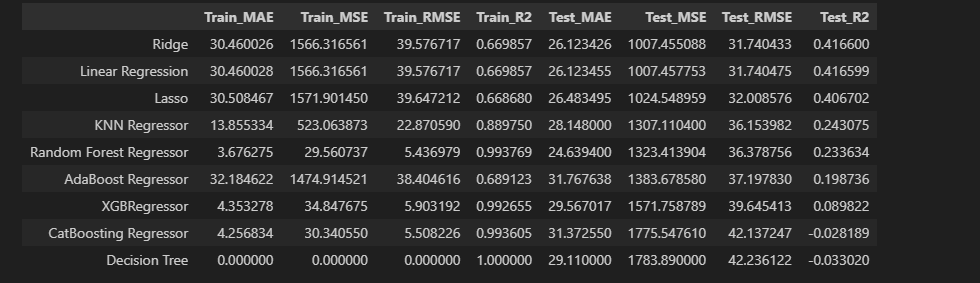

We can see that the best performing base model was the Ridge model so we will use this as the comparison to our best model to see the total performance boost achieved through the feature engineering and hyper parameter tuning. 

**Ridge:**
 - ``Test Set RMSE`` = ``31.740433``
 - ``Test Set R2 Score`` = ``0.4166``

**Best Model (Stack Model):**
 - ``Test Set RMSE`` = ``18.992206``
 - ``Test Set R2 Score`` = ``0.791123``

#### Test RMSE Error Reduction ~ **40.2%**
#### Test R2 Score Improvement ~ **89.9% !!!**

#### Fine-Tuning Stack Model

We can also try fine-tuning the stack model by finding the optimal weights to assign to each base learner. We can do this using using RandomSearchCV on somee different combination of weight parameters to see if performance can be further increased.

In [58]:
stacked_model = VotingRegressor(estimators=[
    ('rf', best_rf_model),
    ('ada', best_ada_model),
    ('knn', best_knn_model)
])

# Define the parameter grid (weights for each model)
param_dist = {
    'weights': [  # Different weight combinations to test
        [1, 1, 1],  # Equal weight
        [2, 1, 1],  # Give more weight to Random Forest
        [1, 2, 1],  # Give more weight to KNN
        [1, 1, 2],  # Give more weight to AdaBoost
        [3, 2, 1],  # Custom combinations
        [2, 3, 1],
        [1, 2, 3],
        [3, 1, 2],
        [0.5, 0.5, 1],  # Some models contribute less
        [1, 0.5, 0.5]
    ]
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=stacked_model,
    param_distributions=param_dist,
    scoring='neg_root_mean_squared_error',
    n_iter=10,
    cv=5, 
    random_state=42,
    n_jobs=-1
)

# Run Randomized Search
random_search.fit(X_train, y_train)

# Print the best weights found
print("Best Weights:", random_search.best_params_)

# Evaluate the best model
stack_model_metrics = {}
best_stack_model = random_search.best_estimator_
y_train_pred_tuned_stack = best_stack_model.predict(X_train)
y_test_pred_tuned_stack = best_stack_model.predict(X_test)

tuned_stack_train_mae, tuned_stack_train_mse, tuned_stack_train_rmse, tuned_stack_train_r2 = evaluate_model(y_train, y_train_pred_tuned_stack)
tuned_stack_test_mae, tuned_stack_test_mse, tuned_stack_test_rmse, tuned_stack_test_r2 = evaluate_model(y_test, y_test_pred_tuned_stack)

stack_model_metrics["Base Stack Model"] = list(tuned_results_df.loc["Stack Model", :]) # Base Stack model for comparison
stack_model_metrics["Tuned Stack Model"] = [tuned_stack_train_mae, tuned_stack_train_mse, tuned_stack_train_rmse, tuned_stack_train_r2, tuned_stack_test_mae, tuned_stack_test_mse, tuned_stack_test_rmse, tuned_stack_test_r2]

tuned_stack_results = get_results_table(stack_model_metrics)



Best Weights: {'weights': [3, 1, 2]}


In [59]:
tuned_stack_results

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Base Stack Model,11.918812,252.247359,15.882297,0.854748,14.005067,360.703876,18.992206,0.791123
Tuned Stack Model,11.057644,232.401468,15.244719,0.866175,13.938991,366.744823,19.150583,0.787624


It seems that the tuned stack model is starting to overfit to the training set. We can try one more approach, where instead of a simple voting regressor we can use a **Meta-Learner Approach**. This will allow us to:
- Capture non-linear relationships between models' predictions.
- Reduce overfitting because the meta-learner generalizes better.
- Have more flexibility since the meta-learner can be any model (e.g., XGBoost, Ridge, Neural Network).

#### Meta-Learner Approach

In [80]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor

# Define base models (previously fine-tuned)
base_models = [
    ('rf', best_rf_model),
    ('ada', best_ada_model),
    ('knn', best_knn_model)
]

# List of meta-learners to try
meta_learners = {
    "Ridge": Ridge(alpha=1.0),
    "XGBoost": XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
}

# Dictionary to store results
meta_model_results = {}
meta_model_objects = {}

# Loop through each meta-learner and evaluate performance
for name, meta_learner in meta_learners.items():
    print(f"Training Stacking Model with {name} as Meta-Learner...")
    
    stacked_meta_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_learner,
        cv=5
    )
    
    # Train the model
    stacked_meta_model.fit(X_train, y_train)

    # Make predictions and evaluate
    y_train_pred_meta_model = stacked_meta_model.predict(X_train)
    y_test_pred_meta_model = stacked_meta_model.predict(X_test)

    stacked_meta_train_mae, stacked_meta_train_mse, stacked_meta_train_rmse, stacked_meta_train_r2 = evaluate_model(y_train, y_train_pred_meta_model)
    stacked_meta_test_mae, stacked_meta_test_mse, stacked_meta_test_rmse, stacked_meta_test_r2 = evaluate_model(y_test, y_test_pred_meta_model)

    meta_model_objects[f"Stacked with {name} meta learner"] = stacked_meta_model
    meta_model_results[f"Stacked with {name} meta learner"] = [stacked_meta_train_mae, stacked_meta_train_mse, stacked_meta_train_rmse, stacked_meta_train_r2, stacked_meta_test_mae, stacked_meta_test_mse, stacked_meta_test_rmse, stacked_meta_test_r2]



Training Stacking Model with Ridge as Meta-Learner...
Training Stacking Model with XGBoost as Meta-Learner...
Training Stacking Model with GradientBoosting as Meta-Learner...


In [81]:
meta_model_results_df = get_results_table(meta_model_results)
meta_model_results_df

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Stacked with XGBoost meta learner,11.367482,246.833023,15.710921,0.857865,13.843640,355.042542,18.842573,0.794401
Stacked with GradientBoosting meta learner,11.322393,247.262290,15.724576,0.857618,14.053119,362.455273,19.038258,0.790108
Stacked with Ridge meta learner,10.736205,229.373176,15.145071,0.867919,14.044677,370.677723,19.252993,0.785347


In [82]:
tuned_stack_results

,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2
Base Stack Model,11.918812,252.247359,15.882297,0.854748,14.005067,360.703876,18.992206,0.791123
Tuned Stack Model,11.057644,232.401468,15.244719,0.866175,13.938991,366.744823,19.150583,0.787624


We can see that the Stacked XGboost meta learner has slightly improved performance over the tuned simple voting regressor stack model. We are starting to see diminishing returns in the performance enhancement via hyperparameter tuning so we will now select the model with best performance as our final model for this problem and save it.

#### **Final Selected Model: Stacked Model with XGBoost Meta Learner**
#### **Final Model Performance:-**
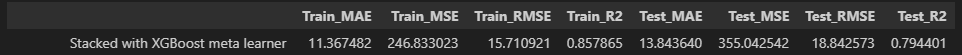

### Save the Model

In [83]:
import joblib

# Save the trained stacked model
joblib.dump(meta_model_objects["Stacked with XGBoost meta learner"], 'models/final_stacked_model.pkl')

['models/final_stacked_model.pkl']